In [1]:
from typing import List, Optional
from tqdm import tqdm
import time

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp


from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

import statsmodels.api as sm
import shap

import warnings

warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
def type_selector(df):

    continuous_columns = df.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()
    #continuous_columns = continuous_columns[1:]

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(df[feature].unique()) < 40
    ]
    categorical_columns = df.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)
    #categorical_columns = categorical_columns[1:]

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    return categorical_columns, continuous_columns

In [3]:
def time_feature(df):
    df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
    
    df["year"] = df["Unnamed: 0"].dt.year
    df["month_of_year"] = df["Unnamed: 0"].dt.month
    df["day_of_week"] = df["Unnamed: 0"].dt.weekday
    df["hour_of_day"] = df["Unnamed: 0"].dt.hour
    df["day_of_month"] = df["Unnamed: 0"].dt.day
    return df

In [4]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print(F'Размерность train {train.shape}')
print(F'Размерность test {test.shape}')

Размерность train (200000, 84)
Размерность test (100000, 80)


In [5]:
train

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,...,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
0,2016-08-18 00:00:00,15.78042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.02723,66.30531,55.10297,73.65612,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-08-18 00:01:00,15.80157,NaN,NaN,NaN,NaN,NaN,53.06440,NaN,NaN,...,53.05109,66.30098,55.11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08-18 00:02:00,15.68913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.06495,66.30359,55.09395,NaN,NaN,55.07365,NaN,NaN,NaN,NaN
3,2016-08-18 00:03:00,15.75101,NaN,20.26209,NaN,NaN,NaN,52.95166,NaN,NaN,...,53.06760,66.28421,55.12513,NaN,92.46913,NaN,NaN,NaN,NaN,NaN
4,2016-08-18 00:04:00,15.57773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.09679,66.26472,55.15526,73.67016,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2017-01-03 21:15:00,12.59146,NaN,NaN,NaN,49.92619,NaN,NaN,42.96059,NaN,...,36.58096,64.48034,45.11026,75.87032,93.66174,NaN,0.001514,0.065270,0.928968,0.004248
199996,2017-01-03 21:16:00,12.66785,NaN,NaN,NaN,NaN,NaN,45.13568,42.03654,NaN,...,36.55834,64.48622,45.10105,NaN,NaN,56.31732,0.001514,0.065273,0.928968,0.004245
199997,2017-01-03 21:17:00,12.74665,NaN,NaN,NaN,NaN,NaN,NaN,41.70169,NaN,...,36.60770,64.47961,45.07452,NaN,NaN,NaN,0.001516,0.065336,0.928906,0.004242
199998,2017-01-03 21:18:00,12.91019,NaN,NaN,NaN,NaN,NaN,44.72477,42.94123,NaN,...,36.57269,64.47457,45.14655,NaN,NaN,NaN,0.001516,0.065333,0.928912,0.004239


In [6]:
test

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,...,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79
0,2017-01-03 21:21:00,12.59972,NaN,NaN,NaN,NaN,NaN,45.27993,43.13644,NaN,...,37.63644,40.64410,53.44470,NaN,36.59567,64.47523,45.08920,NaN,NaN,NaN
1,2017-01-03 21:22:00,12.65850,NaN,NaN,NaN,NaN,NaN,NaN,42.98455,NaN,...,37.69201,40.68030,53.43953,NaN,36.60715,64.48697,45.18127,NaN,NaN,NaN
2,2017-01-03 21:23:00,12.69538,NaN,NaN,NaN,NaN,NaN,NaN,41.87401,NaN,...,37.71147,40.69286,53.42733,NaN,36.60194,64.48034,45.00529,75.84169,NaN,NaN
3,2017-01-03 21:24:00,12.84726,NaN,NaN,NaN,NaN,NaN,NaN,41.78006,NaN,...,37.70427,40.61716,53.44097,NaN,36.61879,64.50220,45.10987,NaN,93.62097,NaN
4,2017-01-03 21:25:00,12.98246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.69343,40.64507,53.51237,NaN,36.59875,64.48300,45.12246,NaN,NaN,56.14647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2017-03-14 07:56:00,12.08330,NaN,NaN,NaN,44.63140,NaN,NaN,NaN,NaN,...,44.72256,50.06271,55.74286,NaN,42.65038,66.08608,53.43510,75.92390,NaN,55.59630
99996,2017-03-14 07:57:00,12.13475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.78089,50.11175,55.76434,NaN,42.68734,66.09002,53.44431,NaN,NaN,55.64390
99997,2017-03-14 07:58:00,12.18710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.82540,50.18184,55.78387,NaN,42.67019,66.11372,53.40477,NaN,103.04540,55.63939
99998,2017-03-14 07:59:00,12.25297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.86958,50.12084,55.89828,NaN,42.66780,66.10795,53.46239,NaN,NaN,55.59716


In [7]:
train.describe()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,...,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
count,1.999340e+05,109370.000000,109456.000000,85.000000,9736.000000,373.000000,88122.000000,16777.000000,407.000000,199837.000000,...,199867.000000,199867.000000,199867.000000,48803.000000,48673.000000,48558.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,1.471747e+01,0.003483,12.696579,9.101270,31.654650,68.328355,47.680708,46.703799,71.668521,23.584873,...,41.898820,66.520646,53.966135,75.458923,94.800765,55.872240,0.001156,0.049836,0.942428,0.006580
std,1.873427e+00,0.017229,4.285856,9.667475,5.039073,13.580792,4.506643,3.940905,0.606023,4.877921,...,7.772574,0.392989,1.512331,0.872953,2.888815,1.450305,0.000085,0.003685,0.003936,0.001442
min,2.215690e-08,-0.005142,0.008831,-3.354573,15.898870,10.271640,22.730830,24.820300,69.825200,8.848302,...,23.078610,62.552550,44.860980,71.780270,90.015210,46.590670,0.000826,0.035611,0.912861,0.002595
25%,1.359252e+01,0.001326,8.111923,4.375712,28.884520,71.918530,45.656210,44.315390,71.271280,19.473280,...,35.693970,66.247250,52.843030,75.441780,93.305450,54.954120,0.001101,0.047461,0.940184,0.005565
50%,1.494062e+01,0.003691,14.088605,9.799968,30.903065,72.293790,47.029165,46.293030,71.680350,24.987920,...,40.920650,66.503290,53.638400,75.831920,94.044160,55.834110,0.001155,0.049773,0.942605,0.006435
75%,1.596708e+01,0.005223,16.081407,9.804002,33.087140,72.644420,48.534740,48.446820,72.021965,27.450710,...,49.107915,66.792830,55.264280,76.018390,95.407530,57.059038,0.001206,0.051962,0.945057,0.007307
max,2.201591e+01,3.886294,22.935910,59.259140,60.604910,75.945500,81.115520,71.128090,74.078940,33.632790,...,57.003070,68.679210,58.624550,77.190620,112.647200,60.550670,0.001865,0.080406,0.956497,0.014346


In [8]:
test.describe()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,...,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79
count,99828.000000,0.0,0.0,78.000000,14939.000000,253.000000,15075.000000,22888.000000,94.000000,99828.000000,...,99828.000000,99828.000000,99828.000000,1689.000000,99828.000000,99828.000000,99828.000000,25134.000000,25062.000000,89034.000000
mean,11.301044,NaN,NaN,8.259843,41.407615,74.353744,48.562236,47.011030,72.535830,28.243433,...,37.375712,48.518393,52.715619,72.800997,35.870347,66.238411,52.266307,76.145161,93.546410,56.186307
std,0.984816,NaN,NaN,3.282814,3.911453,1.140371,1.741324,3.647882,1.719166,1.829707,...,5.049837,0.738174,3.040632,0.124691,4.968143,0.296024,0.680044,0.269156,1.104953,0.962682
min,3.220560,NaN,NaN,0.012514,1.963458,70.963010,39.741910,-5.701760,68.854050,17.935470,...,21.145900,40.576020,37.517330,71.772730,20.574680,64.475230,44.986940,74.598110,89.532410,45.591770
25%,10.693297,NaN,NaN,8.984852,38.639195,73.982380,47.806935,45.012725,71.475152,27.018318,...,33.858123,48.077060,50.832770,72.719760,32.416390,66.042010,51.840950,75.951777,92.870402,55.734475
50%,11.219690,NaN,NaN,9.456869,42.063110,74.526950,48.434970,46.962850,73.077210,28.180595,...,37.569050,48.417800,53.114740,72.804590,36.149480,66.223210,52.195340,76.177615,93.391165,56.227965
75%,11.815215,NaN,NaN,9.798799,44.507690,75.287080,49.070015,48.647073,73.387382,29.367270,...,41.254337,48.862290,54.984330,72.884380,39.572348,66.410790,52.620430,76.319505,94.122135,56.714360
max,15.286960,NaN,NaN,15.827820,57.351200,75.861770,69.288530,71.717910,76.056930,38.283100,...,48.155980,50.847430,58.595240,73.244420,45.905800,68.074200,54.611230,83.859830,110.095000,61.964800


In [9]:
time_feature(train)

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,...,tag79,target1,target2,target3,target4,year,month_of_year,day_of_week,hour_of_day,day_of_month
0,2016-08-18 00:00:00,15.78042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,8,3,0,18
1,2016-08-18 00:01:00,15.80157,NaN,NaN,NaN,NaN,NaN,53.06440,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,8,3,0,18
2,2016-08-18 00:02:00,15.68913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.07365,NaN,NaN,NaN,NaN,2016,8,3,0,18
3,2016-08-18 00:03:00,15.75101,NaN,20.26209,NaN,NaN,NaN,52.95166,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,8,3,0,18
4,2016-08-18 00:04:00,15.57773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,8,3,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2017-01-03 21:15:00,12.59146,NaN,NaN,NaN,49.92619,NaN,NaN,42.96059,NaN,...,NaN,0.001514,0.065270,0.928968,0.004248,2017,1,1,21,3
199996,2017-01-03 21:16:00,12.66785,NaN,NaN,NaN,NaN,NaN,45.13568,42.03654,NaN,...,56.31732,0.001514,0.065273,0.928968,0.004245,2017,1,1,21,3
199997,2017-01-03 21:17:00,12.74665,NaN,NaN,NaN,NaN,NaN,NaN,41.70169,NaN,...,NaN,0.001516,0.065336,0.928906,0.004242,2017,1,1,21,3
199998,2017-01-03 21:18:00,12.91019,NaN,NaN,NaN,NaN,NaN,44.72477,42.94123,NaN,...,NaN,0.001516,0.065333,0.928912,0.004239,2017,1,1,21,3


In [10]:
time_feature(test)

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,...,tag75,tag76,tag77,tag78,tag79,year,month_of_year,day_of_week,hour_of_day,day_of_month
0,2017-01-03 21:21:00,12.59972,NaN,NaN,NaN,NaN,NaN,45.27993,43.13644,NaN,...,64.47523,45.08920,NaN,NaN,NaN,2017,1,1,21,3
1,2017-01-03 21:22:00,12.65850,NaN,NaN,NaN,NaN,NaN,NaN,42.98455,NaN,...,64.48697,45.18127,NaN,NaN,NaN,2017,1,1,21,3
2,2017-01-03 21:23:00,12.69538,NaN,NaN,NaN,NaN,NaN,NaN,41.87401,NaN,...,64.48034,45.00529,75.84169,NaN,NaN,2017,1,1,21,3
3,2017-01-03 21:24:00,12.84726,NaN,NaN,NaN,NaN,NaN,NaN,41.78006,NaN,...,64.50220,45.10987,NaN,93.62097,NaN,2017,1,1,21,3
4,2017-01-03 21:25:00,12.98246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,64.48300,45.12246,NaN,NaN,56.14647,2017,1,1,21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2017-03-14 07:56:00,12.08330,NaN,NaN,NaN,44.63140,NaN,NaN,NaN,NaN,...,66.08608,53.43510,75.92390,NaN,55.59630,2017,3,1,7,14
99996,2017-03-14 07:57:00,12.13475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.09002,53.44431,NaN,NaN,55.64390,2017,3,1,7,14
99997,2017-03-14 07:58:00,12.18710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.11372,53.40477,NaN,103.04540,55.63939,2017,3,1,7,14
99998,2017-03-14 07:59:00,12.25297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.10795,53.46239,NaN,NaN,55.59716,2017,3,1,7,14


In [11]:
categorical_columns, continuous_columns = type_selector(train.drop(['target1', 'target2', 'target3', 'target4', 'Unnamed: 0'], 1))
continuous_columns.sort()

In [12]:
train[categorical_columns].describe()

,tag46,year,month_of_year,day_of_week,hour_of_day,day_of_month
count,98410.0,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.0,2016.020800,10.057600,3.008800,11.491500,16.348800
std,0.0,0.142715,1.846483,2.005378,6.918408,9.005351
min,0.0,2016.000000,1.000000,0.000000,0.000000,1.000000
25%,0.0,2016.000000,9.000000,1.000000,5.000000,8.000000
50%,0.0,2016.000000,10.000000,3.000000,11.000000,17.000000
75%,0.0,2016.000000,11.000000,5.000000,17.000000,24.000000
max,0.0,2017.000000,12.000000,6.000000,23.000000,31.000000


In [13]:
test[categorical_columns].describe()

,tag46,year,month_of_year,day_of_week,hour_of_day,day_of_month
count,99828.0,100000.0,100000.000000,100000.000000,100000.000000,100000.00000
mean,0.0,2017.0,1.787220,3.016000,11.478470,14.28491
std,0.0,0.0,0.742651,1.999946,6.937091,8.34045
min,0.0,2017.0,1.000000,0.000000,0.000000,1.00000
25%,0.0,2017.0,1.000000,1.000000,5.000000,7.00000
50%,0.0,2017.0,2.000000,3.000000,11.000000,13.00000
75%,0.0,2017.0,2.000000,5.000000,17.000000,21.00000
max,0.0,2017.0,3.000000,6.000000,23.000000,31.00000


#### признак tag46 выглядит очень странно , нужно просмотреть его отдельно , в трейне данные за 2016-2017 в тесте тольок 2017 год

In [14]:
train[continuous_columns].describe()

,tag1,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,...,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,tag8,tag9
count,1.999340e+05,199837.000000,199867.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,...,199867.000000,35087.000000,199867.000000,199867.000000,199867.000000,48803.000000,48673.000000,48558.000000,16777.000000,407.000000
mean,1.471747e+01,23.584873,50.128928,-0.000334,0.009145,-0.001012,0.000952,0.000641,0.000594,0.001458,...,56.016110,72.578699,41.898820,66.520646,53.966135,75.458923,94.800765,55.872240,46.703799,71.668521
std,1.873427e+00,4.877921,16.948128,0.002746,0.006391,0.000964,0.000167,0.000156,0.000138,0.000478,...,4.041327,0.235175,7.772574,0.392989,1.512331,0.872953,2.888815,1.450305,3.940905,0.606023
min,2.215690e-08,8.848302,-0.050376,-0.030081,-0.003332,-0.002694,0.000252,0.000161,0.000170,0.000683,...,43.124100,67.901700,23.078610,62.552550,44.860980,71.780270,90.015210,46.590670,24.820300,69.825200
25%,1.359252e+01,19.473280,34.921825,-0.000335,0.004831,-0.002235,0.000843,0.000526,0.000491,0.001129,...,52.935380,72.457090,35.693970,66.247250,52.843030,75.441780,93.305450,54.954120,44.315390,71.271280
50%,1.494062e+01,24.987920,56.727810,0.000118,0.008843,-0.000377,0.000993,0.000610,0.000579,0.001406,...,55.919250,72.586170,40.920650,66.503290,53.638400,75.831920,94.044160,55.834110,46.293030,71.680350
75%,1.596708e+01,27.450710,62.649445,0.000260,0.014776,-0.000219,0.001088,0.000761,0.000693,0.001696,...,59.685215,72.738400,49.107915,66.792830,55.264280,76.018390,95.407530,57.059038,48.446820,72.021965
max,2.201591e+01,33.632790,83.262920,0.108213,0.022987,0.009974,0.001305,0.001309,0.001229,0.041821,...,65.125020,73.605550,57.003070,68.679210,58.624550,77.190620,112.647200,60.550670,71.128090,74.078940


In [15]:
test[continuous_columns].describe()

,tag1,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,...,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,tag8,tag9
count,99828.000000,99828.000000,99828.000000,99833.000000,99836.000000,99836.000000,99836.000000,99827.000000,99836.000000,99836.000000,...,99828.000000,1689.000000,99828.000000,99828.000000,99828.000000,25134.000000,25062.000000,89034.000000,22888.000000,94.000000
mean,11.301044,28.243433,23.157935,-0.000365,0.004475,-0.002460,0.001000,0.000469,0.000385,0.001581,...,52.715619,72.800997,35.870347,66.238411,52.266307,76.145161,93.546410,56.186307,47.011030,72.535830
std,0.984816,1.829707,6.774595,0.001169,0.003759,0.000086,0.000091,0.000218,0.000056,0.000284,...,3.040632,0.124691,4.968143,0.296024,0.680044,0.269156,1.104953,0.962682,3.647882,1.719166
min,3.220560,17.935470,-0.041168,-0.014142,-0.003333,-0.002742,0.000522,-0.000305,0.000241,0.001012,...,37.517330,71.772730,20.574680,64.475230,44.986940,74.598110,89.532410,45.591770,-5.701760,68.854050
25%,10.693297,27.018318,17.973670,-0.000090,0.002213,-0.002523,0.000957,0.000383,0.000346,0.001344,...,50.832770,72.719760,32.416390,66.042010,51.840950,75.951777,92.870402,55.734475,45.012725,71.475152
50%,11.219690,28.180595,23.626520,0.000165,0.004791,-0.002476,0.001016,0.000423,0.000379,0.001560,...,53.114740,72.804590,36.149480,66.223210,52.195340,76.177615,93.391165,56.227965,46.962850,73.077210
75%,11.815215,29.367270,28.537105,0.000295,0.007349,-0.002380,0.001062,0.000477,0.000417,0.001746,...,54.984330,72.884380,39.572348,66.410790,52.620430,76.319505,94.122135,56.714360,48.647073,73.387382
max,15.286960,38.283100,44.218840,0.031430,0.013001,-0.002142,0.001256,0.002617,0.000708,0.002426,...,58.595240,73.244420,45.905800,68.074200,54.611230,83.859830,110.095000,61.964800,71.717910,76.056930


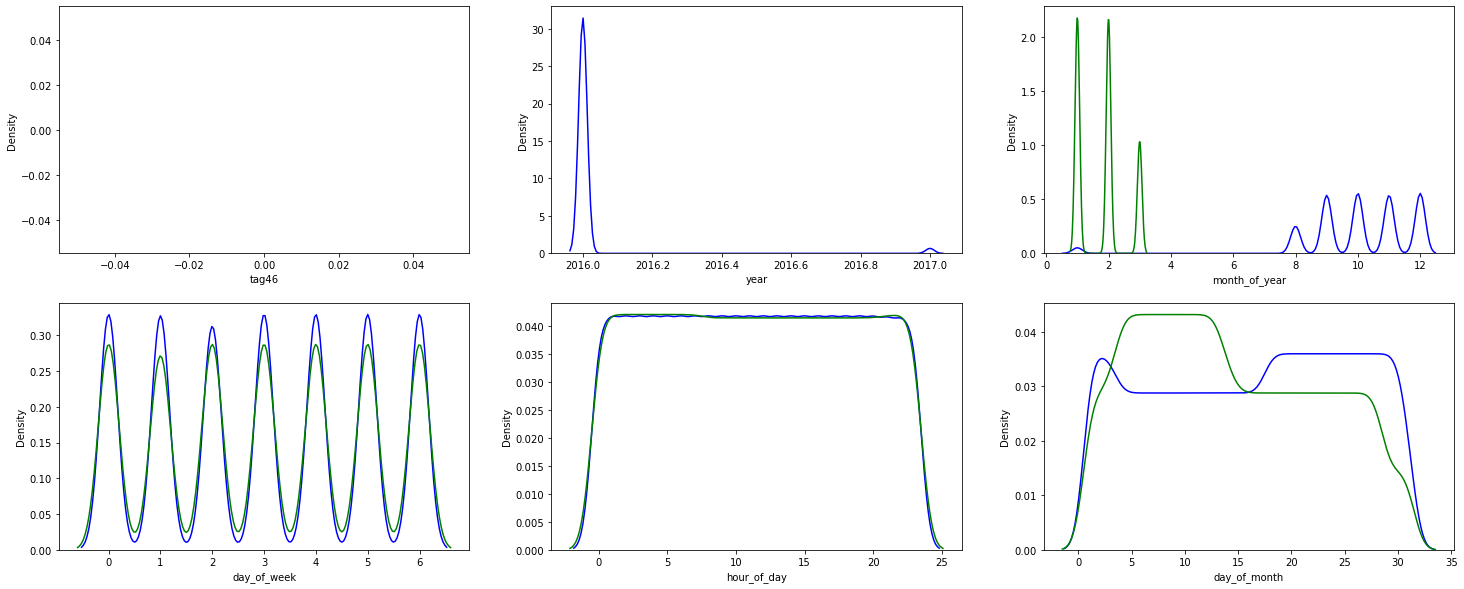

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(25, 10))

for num, feature in enumerate(categorical_columns):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//3, num%3], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//3, num%3], color="green", label="test")

#### tag46 как и ожидалось мусорный признак его можно удалить , так же видно что данные за разные временные промежутки (год, месяц)


In [17]:
train = train.drop(['tag46','year','month_of_year','day_of_month'],1)
test = test.drop(['tag46','year','month_of_year','day_of_month'],1)
categorical_columns, continuous_columns = type_selector(train.drop(['target1', 'target2', 'target3', 'target4', 'Unnamed: 0'], 1))

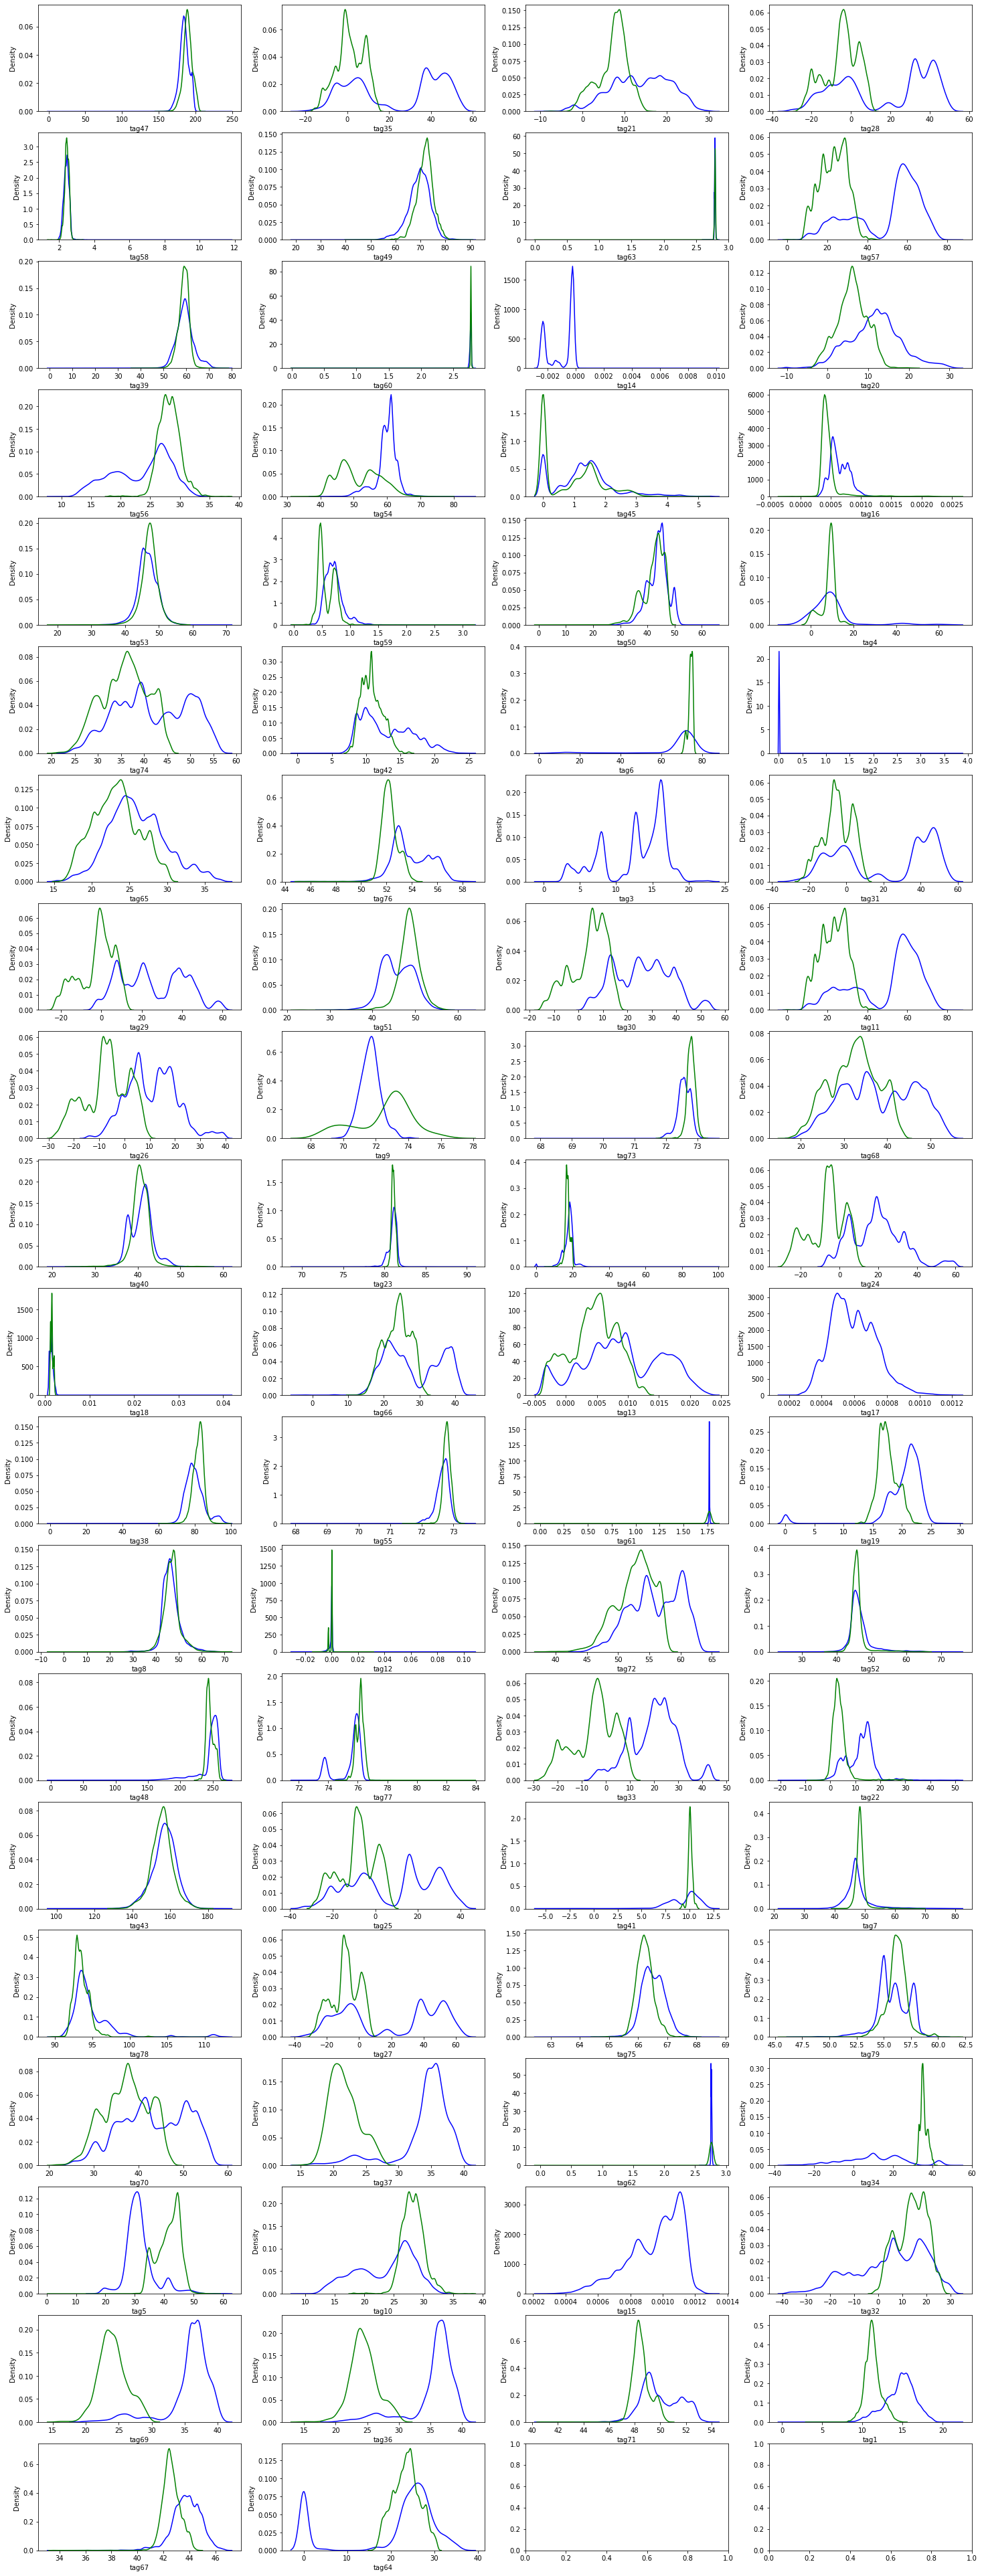

In [18]:
fig, axes = plt.subplots(20, 4, figsize=(25, 70))

for num, feature in enumerate(continuous_columns):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")

#### распределения большинства признаков очень отличаются, так же есть признаки которые есть только в трейне

<AxesSubplot:>

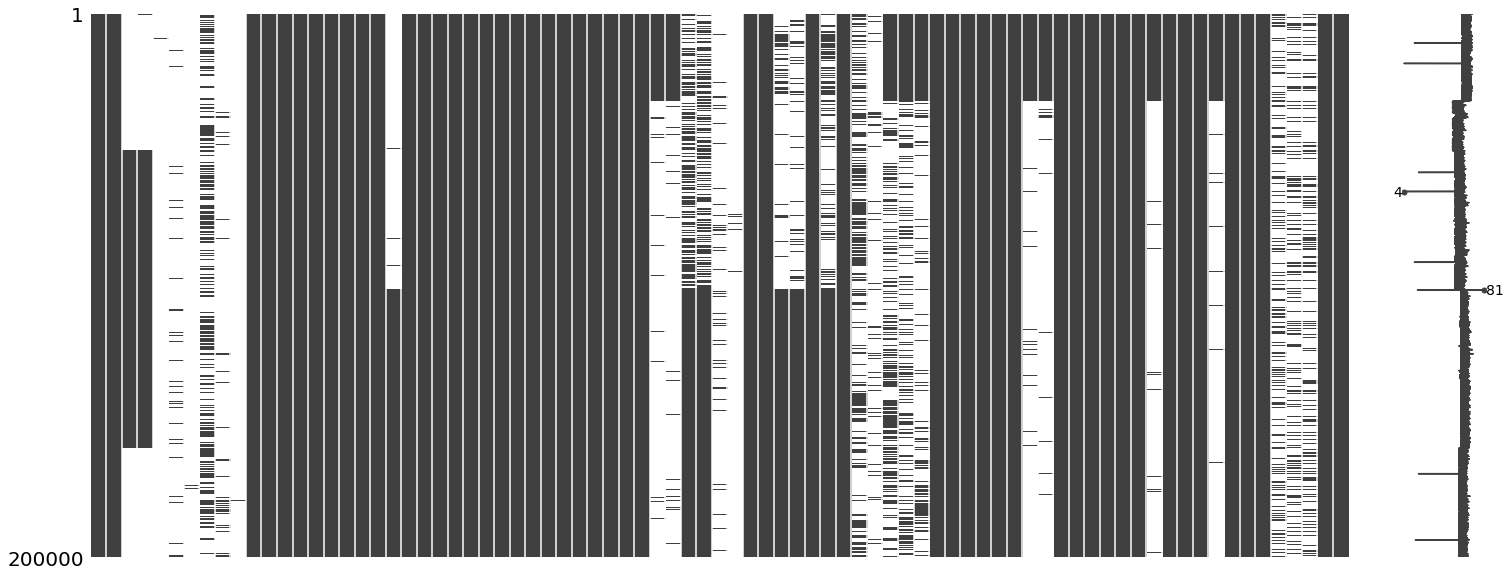

In [19]:
msno.matrix(train.drop(['target1','target2', 'target3','target4'],1))

<AxesSubplot:>

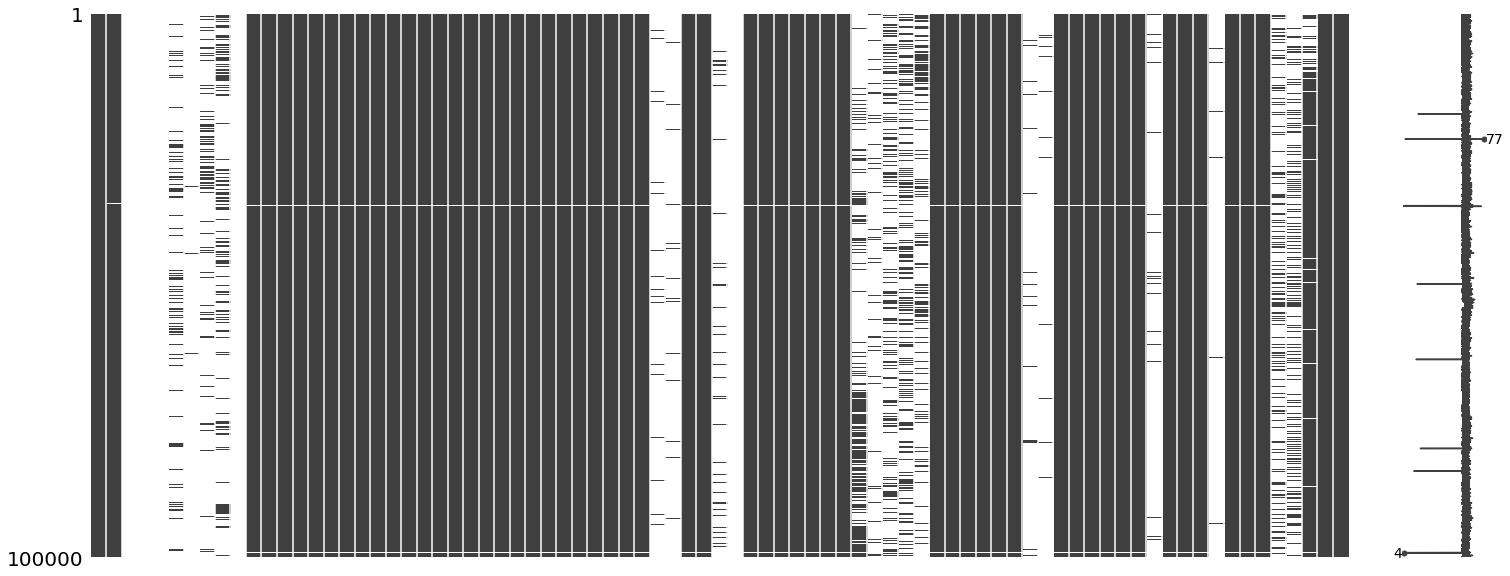

In [20]:
msno.matrix(test)

##### некоторое количество строк в тесте отстутствуют практически полностью, возможно была ошибка записи в бд

<AxesSubplot:>

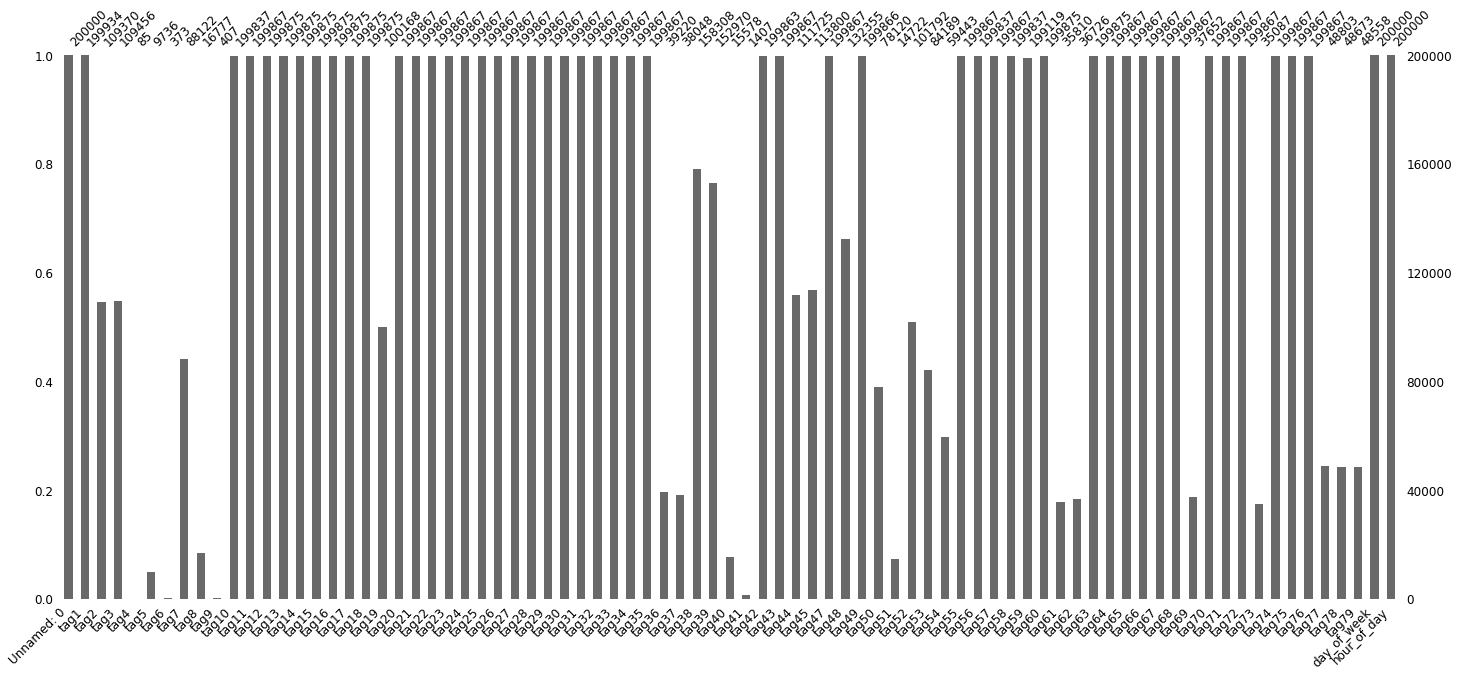

In [21]:
msno.bar(train.drop(['target1','target2', 'target3','target4'],1), labels=True ,fontsize = 12)

<AxesSubplot:>

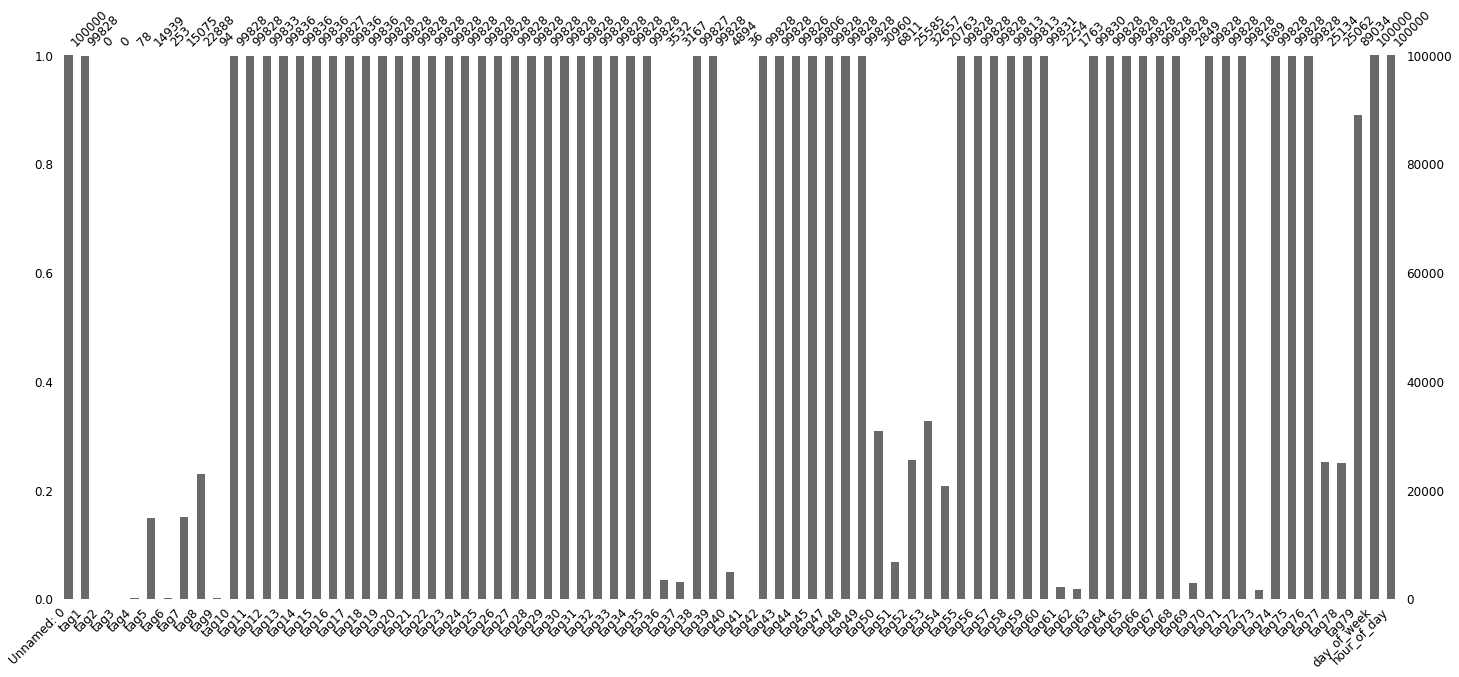

In [22]:
msno.bar(test, labels=True, fontsize = 12)

(0.0, 85.0)

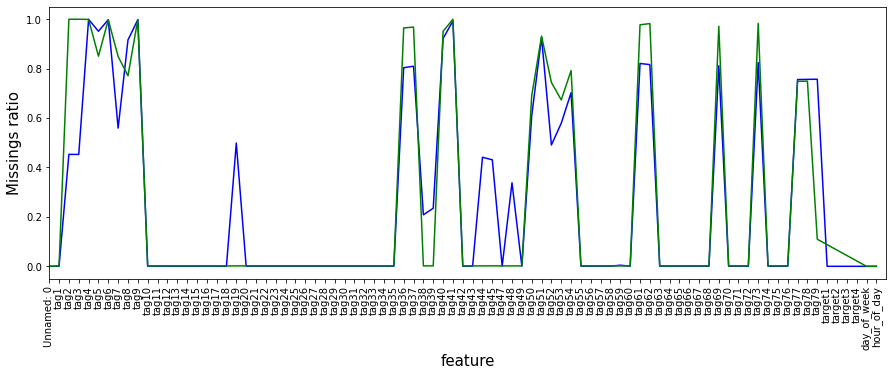

In [23]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train.isnull().mean(), label="train", color="blue")
plt.plot(test.isnull().mean(), label="test", color="green")
plt.xticks(range(train.shape[1]), train.columns, rotation=90)
plt.ylabel("Missings ratio", size=15)
plt.xlabel("feature", size=15)
plt.xlim(0, train.shape[1])

для начала уберем признаки tag2- tag3 потому что в трейне имеются наблюдения по этим признакам а в тесте нет. 
попробовать оставить признаки с большим кол-вом пропусков но с наблюдениями имеющимеся и в трейне и тесте. и попробовать без них 

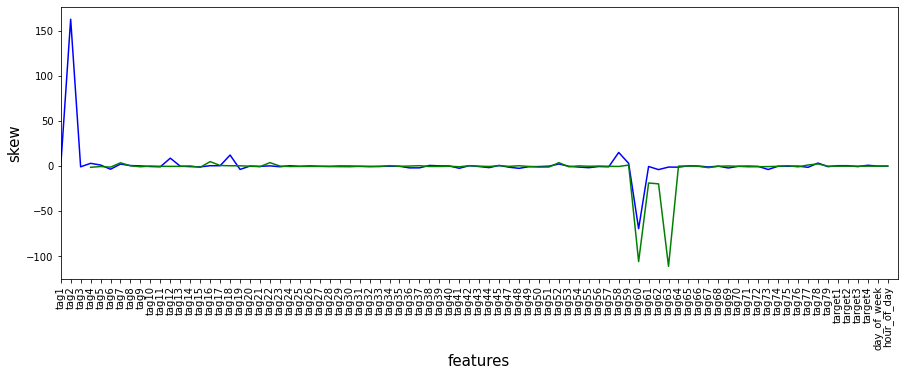

In [24]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.skew(), test.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

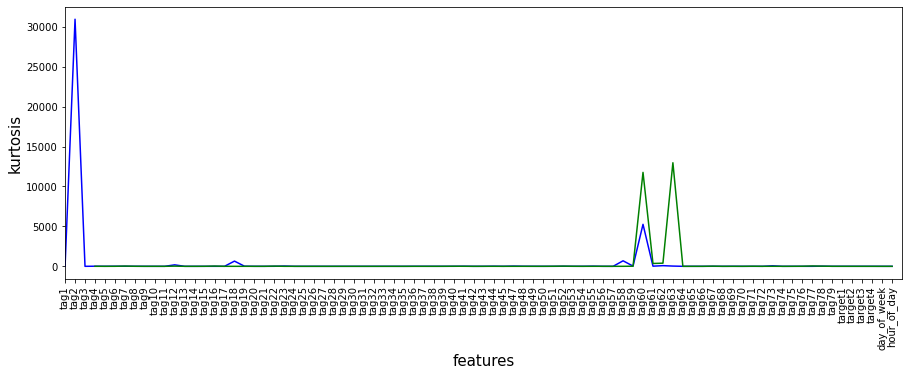

In [25]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.kurtosis(), test.kurtosis()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.show()

In [26]:
correlation = train.corr()
corr_with_target = correlation["target1"].sort_values(ascending = False)
corr_with_target.head()

target1    1.000000
target2    0.999999
tag49      0.527675
tag1       0.313592
tag5       0.295950
Name: target1, dtype: float64

In [27]:
corr_with_target.tail()

tag71     -0.339693
tag76     -0.362139
tag67     -0.506179
tag75     -0.551591
target3   -0.930867
Name: target1, dtype: float64

Text(0, 0.5, 'Density')

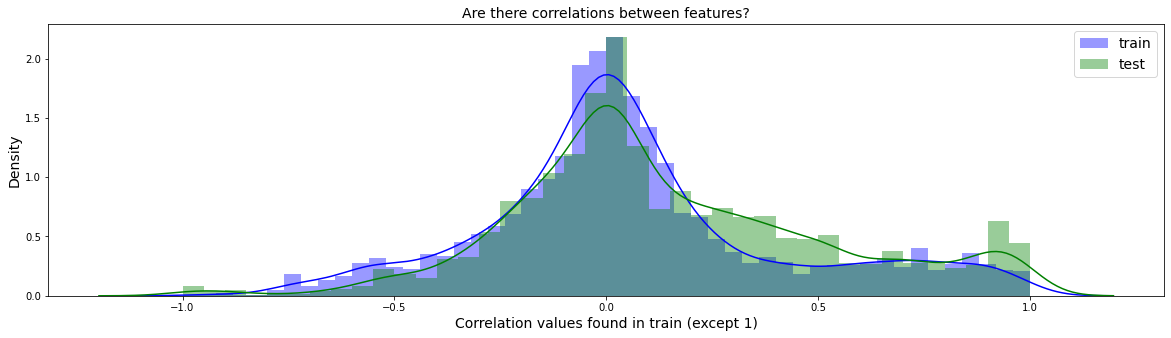

In [28]:
train_correlations = train.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = train.columns.tolist()
columns.remove("target1")
columns.remove("target2")
columns.remove("target3")
columns.remove("target4")

test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

<AxesSubplot:title={'center':'Correlation of Numeric Features with Sale Price'}>

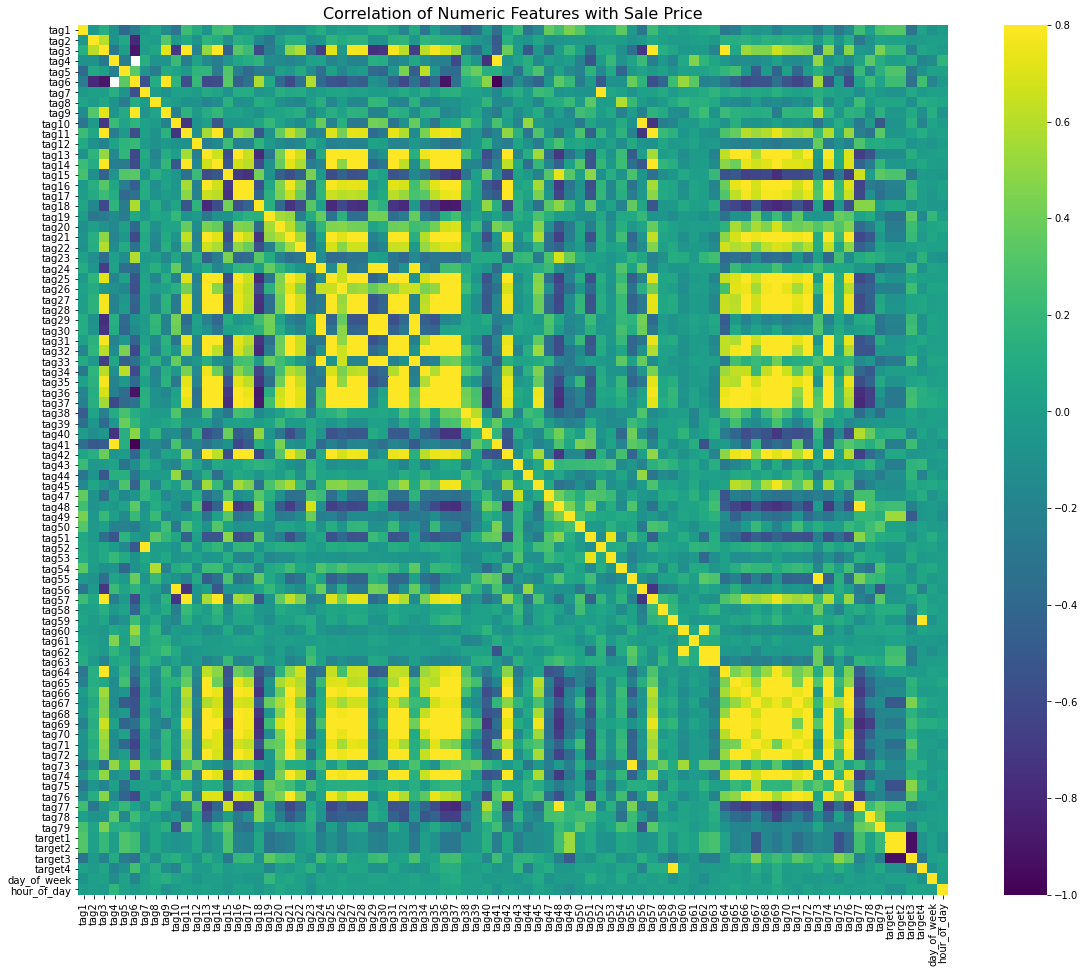

In [29]:
fig, axes = plt.subplots(figsize = (20,16))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

In [30]:
categorical_columns, continuous_columns = type_selector(train.drop(['target2', 'target3', 'target4', 'target1', 'Unnamed: 0','tag2', 'tag3'
                               ],1))

target 1-target2 имеют сильную кореляцию друг с другом , target3 имеет сильнуо обратную связь с target1-target2

In [31]:
cv = 1
features_to_score = train[categorical_columns+continuous_columns].columns.tolist()

In [32]:
%%time



while np.mean(cv) > 0.93:
    
    X_adv = pd.concat([
    train[features_to_score], test[features_to_score]
                        ])
    y_adv = np.hstack(
        (np.ones(train.shape[0]), np.zeros(test.shape[0])))

    X_adv = X_adv.reset_index(drop=True)

    parameters = {#"max_depth": 4,
        "n_estimators": 25, "random_state": 27,"objective": "binary", "n_jobs": -1 }
    model = lgbm.LGBMClassifier(**parameters)
    
    model.fit(X_adv, y_adv)
    
    cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
    )

    print(f"CV-score: {round(np.mean(cv), 4)}")
    print(len(features_to_score))

    importance = pd.DataFrame({
        "feature": X_adv.columns,
        "adversarial_importance": model.feature_importances_
                                })
    importance = importance.sort_values(by="adversarial_importance", ascending=False)
    importance = importance.head(n=100)
    
    features_to_score = importance[1:]
    features_to_score = features_to_score['feature'].tolist()
    



    

CV-score: 1.0
78
CV-score: 1.0
77
CV-score: 1.0
76
CV-score: 1.0
75
CV-score: 1.0
74
CV-score: 1.0
73
CV-score: 1.0
72
CV-score: 1.0
71
CV-score: 1.0
70
CV-score: 1.0
69
CV-score: 1.0
68
CV-score: 1.0
67
CV-score: 0.9999
66
CV-score: 1.0
65
CV-score: 1.0
64
CV-score: 1.0
63
CV-score: 0.9999
62
CV-score: 0.9998
61
CV-score: 0.9997
60
CV-score: 0.9997
59
CV-score: 0.9997
58
CV-score: 0.9995
57
CV-score: 0.9994
56
CV-score: 0.9993
55
CV-score: 0.9993
54
CV-score: 0.9993
53
CV-score: 0.9991
52
CV-score: 0.9988
51
CV-score: 0.9987
50
CV-score: 0.9985
49
CV-score: 0.9975
48
CV-score: 0.9975
47
CV-score: 0.9973
46
CV-score: 0.9971
45
CV-score: 0.9966
44
CV-score: 0.9961
43
CV-score: 0.9952
42
CV-score: 0.9938
41
CV-score: 0.9945
40
CV-score: 0.9935
39
CV-score: 0.9916
38
CV-score: 0.9898
37
CV-score: 0.9887
36
CV-score: 0.9874
35
CV-score: 0.9852
34
CV-score: 0.9813
33
CV-score: 0.9802
32
CV-score: 0.9791
31
CV-score: 0.9758
30
CV-score: 0.971
29
CV-score: 0.9682
28
CV-score: 0.9619
27
CV-sco

отделив признаки которые сильно отличаются на трейне от теста построим модель

In [33]:
features_to_score

['tag77',
 'tag78',
 'tag7',
 'tag52',
 'tag43',
 'tag5',
 'tag8',
 'tag54',
 'day_of_week',
 'tag36',
 'tag51',
 'tag69',
 'tag37',
 'tag40',
 'tag53',
 'tag41',
 'hour_of_day',
 'tag73',
 'tag62',
 'tag61',
 'tag4',
 'tag6',
 'tag9']

In [34]:
def group_by_stat(df,features_list, feature):
    
    for item in features_list:
        df[item+"_mean"] = df.groupby(item)[feature].transform('mean')
        df[item+"_median"] = df.groupby(item)[feature].transform('median')
        df[item+"_std"] = df.groupby(item)[feature].transform('std')
        df[item+"_count"] = df.groupby(item)[feature].transform('count')
        df[item+"_min"] = df.groupby(item)[feature].transform('min')
        df[item+"_max"] = df.groupby(item)[feature].transform('max')
        df[item+"_summ"] = df.groupby(item)[feature].transform('sum')
    
    return df

In [35]:
def freq_encoder(df,features_list):
    
    for item in features_list:
        freq_encoder = df[item].value_counts(normalize=True)
        df[item+"_freq_enc"] = df[item].map(freq_encoder)
    
    return df

In [36]:
categorical_columns, continuous_columns = type_selector(train[features_to_score])

In [37]:
train_freq_encoder = freq_encoder(train[features_to_score], categorical_columns+continuous_columns)
test_freq_encoder = freq_encoder(test[features_to_score], categorical_columns+continuous_columns)


In [38]:
train_freq_encoder

,tag77,tag78,tag7,tag52,tag43,tag5,tag8,tag54,day_of_week,tag36,...,tag52_freq_enc,tag77_freq_enc,tag69_freq_enc,tag51_freq_enc,tag9_freq_enc,tag43_freq_enc,tag36_freq_enc,tag73_freq_enc,tag54_freq_enc,tag41_freq_enc
0,73.65612,NaN,NaN,50.50632,164.9857,NaN,NaN,61.20765,3,37.12356,...,0.00001,0.000041,0.000027,NaN,NaN,0.000010,0.000051,0.000114,0.000017,NaN
1,NaN,NaN,53.06440,50.49541,164.1665,NaN,NaN,61.20348,3,37.09820,...,0.00001,NaN,0.000053,NaN,NaN,0.000010,0.000051,0.000200,0.000017,NaN
2,NaN,NaN,NaN,50.49607,166.6839,NaN,NaN,61.20309,3,37.10657,...,0.00001,NaN,0.000053,NaN,NaN,0.000010,0.000025,0.000257,0.000017,NaN
3,NaN,92.46913,52.95166,50.51320,163.1378,NaN,NaN,61.28067,3,37.14546,...,0.00001,NaN,0.000027,NaN,NaN,0.000010,0.000025,0.000200,0.000017,NaN
4,73.67016,NaN,NaN,50.50373,166.8106,NaN,NaN,61.28010,3,37.13568,...,0.00001,0.000020,0.000053,NaN,NaN,0.000010,0.000025,0.000228,0.000017,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,75.87032,93.66174,NaN,NaN,146.0350,49.92619,42.96059,NaN,1,NaN,...,NaN,0.000041,NaN,NaN,NaN,0.000015,NaN,NaN,NaN,NaN
199996,NaN,NaN,45.13568,NaN,146.6044,NaN,42.03654,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000005,NaN,NaN,NaN,NaN
199997,NaN,NaN,NaN,42.78935,146.3944,NaN,41.70169,NaN,1,NaN,...,0.00001,NaN,NaN,NaN,NaN,0.000005,NaN,NaN,NaN,NaN
199998,NaN,NaN,44.72477,NaN,145.8767,NaN,42.94123,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000005,NaN,NaN,NaN,NaN


In [39]:
categorical_columns, continuous_columns = type_selector(train_freq_encoder)

In [40]:
train_grouped_by_stat= group_by_stat(train_freq_encoder, categorical_columns+continuous_columns, 'day_of_week')
test_grouped_by_stat= group_by_stat(test_freq_encoder, categorical_columns+continuous_columns,'day_of_week')

In [41]:
train_grouped_by_stat= group_by_stat(train_grouped_by_stat, categorical_columns+continuous_columns, 'hour_of_day')
test_grouped_by_stat= group_by_stat(test_grouped_by_stat, categorical_columns+continuous_columns,'hour_of_day')

Обучение на target1

In [42]:
train_target_1 = train['target1'].drop(train.index[:9]).reset_index(drop=True)
train_grouped_by_stat = train_grouped_by_stat.drop(train_grouped_by_stat.index[:9]).reset_index(drop=True)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train_grouped_by_stat, 
                                                    train_target_1, random_state=0)

In [44]:
model = lgbm.LGBMRegressor( max_depth=7,
                             #min_child_samples=41,
                             #max_bin=52,
                             #num_leaves=17,
                             verbose_eval = 100,
                             learning_rate = 0.05,
                             random_state=42,
                             #early_stopping_rounds=50,
                             n_estimators=4500,
                             #num_boost_round=1000,
                             n_jobs= -1
                            
                                           )

cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
R2: 0.560 +- 0.004


In [45]:
model.fit(train_grouped_by_stat,train_target_1 )

[LightGBM] [Warning] Unknown parameter: verbose_eval


LGBMRegressor(learning_rate=0.05, max_depth=7, n_estimators=4500,
              random_state=42, verbose_eval=100)

In [46]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

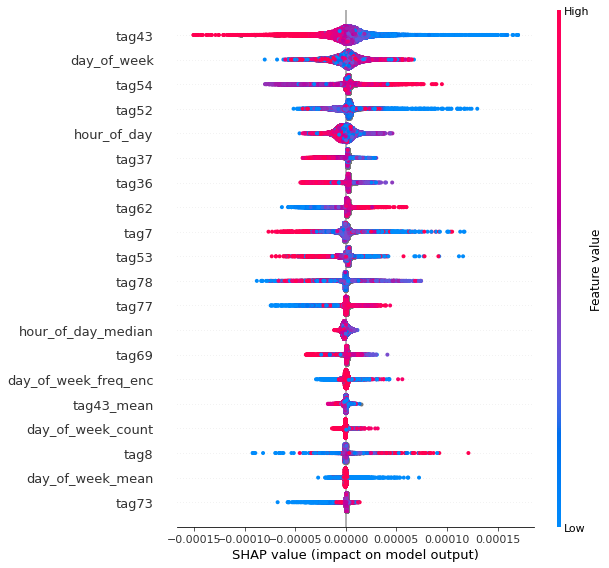

In [47]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=20, auto_size_plot=None)

In [48]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']

4      0.000014
8      0.000009
7      0.000007
3      0.000006
16     0.000006
         ...   
178    0.000000
179    0.000000
180    0.000000
181    0.000000
184    0.000000
Name: feature_importance_vals, Length: 368, dtype: float64

In [49]:
feature_importance.head(10)

,col_name,feature_importance_vals
4,tag43,0.000014
8,day_of_week,0.000009
7,tag54,0.000007
3,tag52,0.000006
16,hour_of_day,0.000006
12,tag37,0.000004
9,tag36,0.000004
18,tag62,0.000004
2,tag7,0.000004
14,tag53,0.000004


In [50]:
predicted_target1 = model.predict(test_grouped_by_stat)

In [51]:
predicted_target1

array([0.00150975, 0.00149389, 0.00148668, ..., 0.00116092, 0.00116086,
       0.00122557])

предсказание target 2

In [52]:
train_target_2 = train['target2'].drop(train.index[:9]).reset_index(drop=True)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(train_grouped_by_stat, 
                                                    train_target_2, random_state=0)

In [54]:
model = lgbm.LGBMRegressor( max_depth=7,
                             #min_child_samples=41,
                             #max_bin=52,
                             #num_leaves=17,
                             learning_rate = 0.05,
                             random_state=42,
                             #early_stopping_rounds=50,
                             n_estimators=4500,
                             #num_boost_round=10000
                             n_jobs= -1
                            
                                           )

cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.560 +- 0.003


In [55]:
model.fit(train_grouped_by_stat,train_target_2 )

LGBMRegressor(learning_rate=0.05, max_depth=7, n_estimators=4500,
              random_state=42)

In [56]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

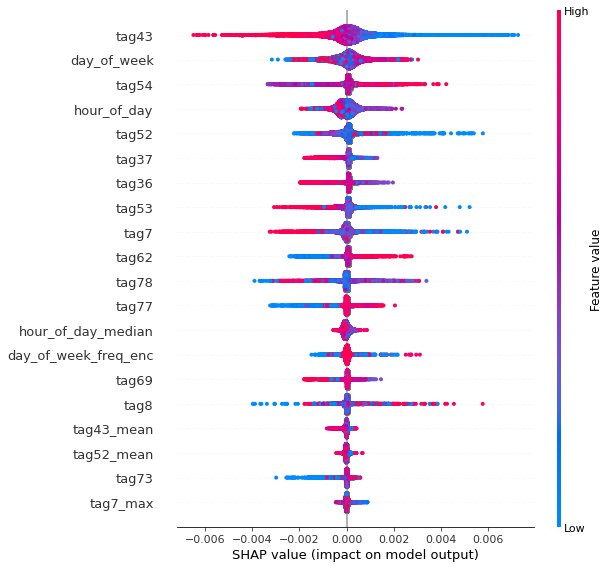

In [57]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=20, auto_size_plot=None)

In [58]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']

4      0.000604
8      0.000402
7      0.000309
16     0.000254
3      0.000236
         ...   
182    0.000000
183    0.000000
70     0.000000
185    0.000000
184    0.000000
Name: feature_importance_vals, Length: 368, dtype: float64

In [59]:
feature_importance.head(10)


,col_name,feature_importance_vals
4,tag43,0.000604
8,day_of_week,0.000402
7,tag54,0.000309
16,hour_of_day,0.000254
3,tag52,0.000236
12,tag37,0.000189
9,tag36,0.000181
14,tag53,0.000171
2,tag7,0.000170
18,tag62,0.000168


In [60]:
predicted_target2 = model.predict(test_grouped_by_stat)

target3

In [61]:
train_target_3 = train['target3'].drop(train.index[:9]).reset_index(drop=True)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(train_grouped_by_stat, 
                                                    train_target_3, random_state=0)

In [63]:
model = lgbm.LGBMRegressor( max_depth=7,
                             #min_child_samples=41,
                             #max_bin=52,
                             #num_leaves=17,
                             learning_rate = 0.05,
                             random_state=42,
                             #early_stopping_rounds=50,
                             n_estimators=4500,
                             #num_boost_round=10000
                             n_jobs= -1
                            
                                           )

cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.511 +- 0.002


In [64]:
model.fit(train_grouped_by_stat,train_target_3 )

LGBMRegressor(learning_rate=0.05, max_depth=7, n_estimators=4500,
              random_state=42)

In [65]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

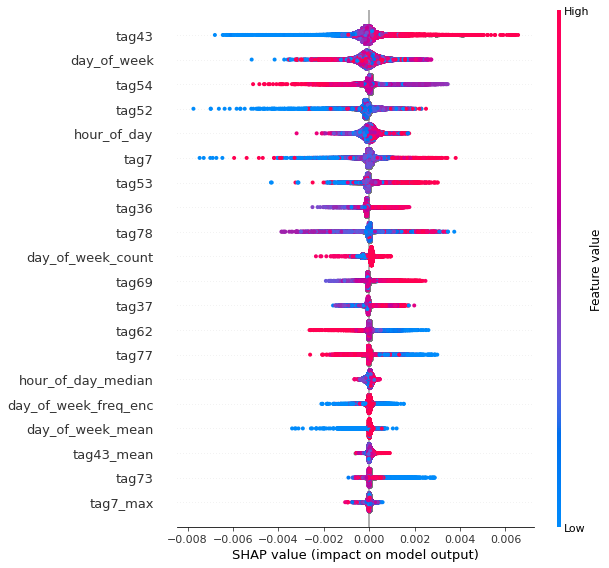

In [66]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=20, auto_size_plot=None)

In [67]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']

4      0.000451
8      0.000365
7      0.000277
3      0.000265
16     0.000209
         ...   
179    0.000000
180    0.000000
181    0.000000
182    0.000000
184    0.000000
Name: feature_importance_vals, Length: 368, dtype: float64

In [68]:
feature_importance.head(10)

,col_name,feature_importance_vals
4,tag43,0.000451
8,day_of_week,0.000365
7,tag54,0.000277
3,tag52,0.000265
16,hour_of_day,0.000209
2,tag7,0.000195
14,tag53,0.000193
9,tag36,0.000181
1,tag78,0.000162
11,tag69,0.000144


In [69]:
predicted_target3 = model.predict(test_grouped_by_stat)

target4

In [70]:
train_target_4 = train['target4'].drop(train.index[:9]).reset_index(drop=True)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(train_grouped_by_stat, 
                                                    train_target_4, random_state=0)

In [72]:
model = lgbm.LGBMRegressor( max_depth=7,
                             #min_child_samples=41,
                             #max_bin=52,
                             #num_leaves=17,
                             learning_rate = 0.05,
                             random_state=42,
                             #early_stopping_rounds=50,
                             n_estimators=4500,
                             #num_boost_round=10000
                             n_jobs= -1
                            
                                           )

cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.519 +- 0.005


In [73]:
model.fit(train_grouped_by_stat,train_target_4 )

LGBMRegressor(learning_rate=0.05, max_depth=7, n_estimators=4500,
              random_state=42)

In [74]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

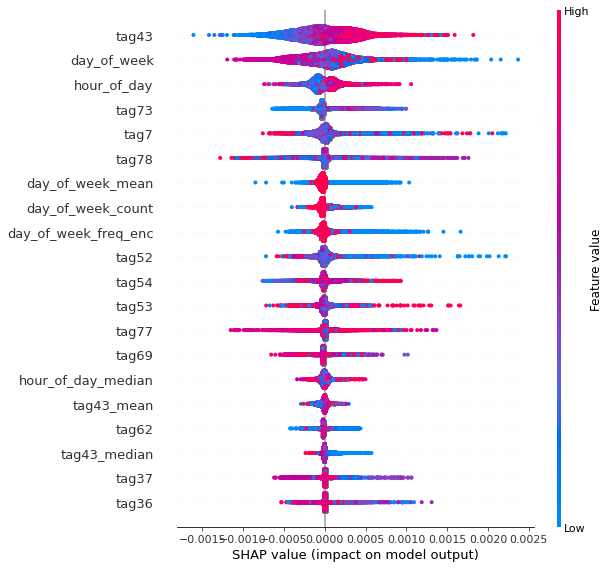

In [75]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=20, auto_size_plot=None)

In [76]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']

4      0.000270
8      0.000230
16     0.000103
17     0.000090
2      0.000082
         ...   
191    0.000000
192    0.000000
193    0.000000
194    0.000000
184    0.000000
Name: feature_importance_vals, Length: 368, dtype: float64

In [77]:
feature_importance.head(10)

,col_name,feature_importance_vals
4,tag43,0.000270
8,day_of_week,0.000230
16,hour_of_day,0.000103
17,tag73,0.000090
2,tag7,0.000082
1,tag78,0.000064
46,day_of_week_mean,0.000060
49,day_of_week_count,0.000056
23,day_of_week_freq_enc,0.000055
3,tag52,0.000055


In [78]:
predicted_target4 = model.predict(test_grouped_by_stat)

In [79]:
predicted_target4

array([0.00400913, 0.00456102, 0.00468091, ..., 0.00801852, 0.0070327 ,
       0.00753567])

In [80]:
preds_final = pd.DataFrame()
preds_final['target1_pred'] = predicted_target1.copy()
preds_final['target2_pred'] = predicted_target2.copy()
preds_final['target3_pred'] = predicted_target3.copy()
preds_final['target4_pred'] = predicted_target4.copy()

In [82]:
preds_final

,target1_pred,target2_pred,target3_pred,target4_pred
0,0.001510,0.064630,0.929748,0.004009
1,0.001494,0.065124,0.929630,0.004561
2,0.001487,0.063707,0.933380,0.004681
3,0.001494,0.066630,0.932174,0.005303
4,0.001207,0.051513,0.941031,0.005503
...,...,...,...,...
99995,0.001259,0.054378,0.937735,0.007429
99996,0.001164,0.050031,0.942103,0.006620
99997,0.001161,0.048950,0.944237,0.008019
99998,0.001161,0.050611,0.941794,0.007033
